### Diagram Creation

This notebook creates the subfigures used in the diagram illustrating our method found in the paper. 

We do this by applying our method on a synthetic two dimensional dataset.

In [1]:
import apoNN.src.data as apoData
import apoNN.src.utils as apoUtils
import apoNN.src.vectors as vectors
import apoNN.src.fitters as fitters
import apoNN.src.evaluators as evaluators
import apoNN.src.occam as occam_utils

import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import random

[(['TEFF', 'LOGG', 'LOG10VDOP', 'METALS', 'C', 'N', 'O Mg Si S Ca Ti'], ['C', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'S', 'K', 'Ca', 'Ti', 'V', 'Mn', 'Fe', 'Ni'], ['[C/M]', '[N/M]', '[O/M]', '[Na/H]', '[Mg/M]', '[Al/H]', '[Si/M]', '[S/M]', '[K/H]', '[Ca/M]', '[Ti/M]', '[V/H]', '[Mn/H]', '[Fe/H]', '[Ni/H]'], [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1])]


### Create dataset

We model the full stellar dataset using a gaussian mixture model. Clusters are gaussians sharing a common covariance but each with their own mean.

In [2]:
cov = np.array([[0.4,0.3],[0.3,1.3]])
mean = [0,0]
scaling_factor = np.array([0.3,0.7])
number_cluster = 5
number_cluster_members = 15

In [3]:
random_stars = np.random.multivariate_normal(mean,cov,size=2000)

In [4]:
eigenvalues,eigenvectors = np.linalg.eig(cov)
eigenvalues_matrix = np.diag(eigenvalues)
eigenvalues_cluster = np.multiply(eigenvalues,scaling_factor)
eigenvalues_cluster_matrix = np.diag(eigenvalues_cluster)


In [5]:
cov_intracluster = np.dot(np.dot(eigenvectors,eigenvalues_cluster_matrix),np.linalg.inv(eigenvectors))
cov_intercluster = cov-cov_intracluster

In [6]:
cluster_centers = np.random.multivariate_normal(mean,cov_intercluster,size=number_cluster)
cluster_stars = []
cluster_names = []
for i,cluster_center in enumerate(cluster_centers):
    cluster_members = cluster_center + np.random.multivariate_normal(mean,cov_intracluster,size=number_cluster_members)
    cluster_stars.append(cluster_members)
    cluster_names.append(np.array([str(i)]*number_cluster_members))
cluser_stars = np.array(cluster_stars)
cluster_names = np.array(cluster_names)

In [7]:
z = vectors.Vector(random_stars.reshape(-1,2))
z_occam = vectors.OccamVector(cluster_names.reshape(-1),val=cluser_stars.reshape(-1,2))


### Transforming the space

In [8]:
fitter = fitters.StandardFitter(z,z_occam,use_whitening=True)

Now that we have the scaling. We want to break it down into the individual matrix components equivalent to the steps of our method

In [9]:
base_vector = vectors.Vector(val = np.array([[0,1],[1,0]]) )
z_whitened = z.whitened(fitter.whitener)
z_new_basis = fitter.transform(z.centered(),scaling=False)
z_scaled = fitter.transform(z.centered(),scaling=True)

In [10]:
def linear_transformation(vector,before_vector,after_vector):
    """Reproduces a linear transformation from a set of vectors before and after transformation to a new vector. """
    transform = np.dot(np.linalg.pinv(after_vector.val),before_vector.val)
    transformed_vector = np.dot(vector.val,transform)
    return transformed_vector

In [11]:
basis_whitened = linear_transformation(base_vector,z,z_whitened)
basis_new_basis= linear_transformation(base_vector,z,z_new_basis)
basis_scaled= linear_transformation(base_vector,z,z_scaled)

### Diagram

In [12]:
def forceAspect(ax,aspect=1):
    """Make axis encode the same euclidian distance"""
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

In [40]:
lim = 3.4

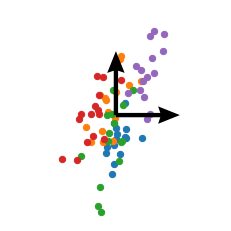

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
for cluster_name in list(z_occam.registry.keys()):
    members = z_occam.centered().only(cluster_name).val
    ax.scatter(members[:,0],members[:,1],s=40)

ax.quiver([0, 0], [0, 0], np.array([0, 1])*2, np.array([1, 0])*2,angles='xy', scale_units='xy', scale=1.,color="black",width=0.02,headwidth=4)
ax.set_ylim(-lim,lim)
ax.set_xlim(-lim,lim)
ax.set_aspect('equal', adjustable='box')
ax.axis("off")
plt.savefig("../../figures/diagram/initial_representation.png",format="png",quality=100)

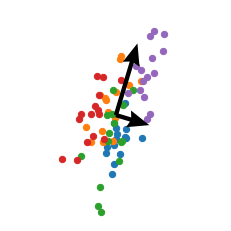

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111)
for cluster_name in list(z_occam.registry.keys()):
    members = z_occam.centered().only(cluster_name).val
    ax.scatter(members[:,0],members[:,1],s=40)
#plt.scatter(z()[:,0],z()[:,1],s=1,alpha=0.2)

plt.quiver([0, 0], [0, 0], basis_whitened[:,0]*2, basis_whitened[:,1]*2,angles='xy', scale_units='xy', scale=1.,color="black",width=0.02,headwidth=4)
ax.set_ylim(-lim,lim)
ax.set_xlim(-lim,lim)
ax.set_aspect('equal', adjustable='box')
ax.axis("off")
plt.savefig("../../figures/diagram/whiten_representation.png",format="png",quality=100)

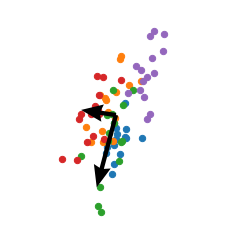

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)
for cluster_name in list(z_occam.registry.keys()):
    members = z_occam.centered().only(cluster_name).val
    ax.scatter(members[:,0],members[:,1],s=40)
#plt.scatter(z()[:,0],z()[:,1],s=1,alpha=0.2)

plt.quiver([0, 0], [0, 0], basis_new_basis[:,0]*2, basis_new_basis[:,1]*2,angles='xy', scale_units='xy', scale=1.,color="black",width=0.02,headwidth=4)
ax.set_ylim(-lim,lim)
ax.set_xlim(-lim,lim)
ax.set_aspect('equal', adjustable='box')
ax.axis("off")
plt.savefig("../../figures/diagram/changed_basis_representation.png",format="png",quality=100)

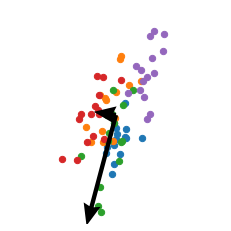

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)
for cluster_name in list(z_occam.registry.keys()):
    members = z_occam.centered().only(cluster_name).val
    ax.scatter(members[:,0],members[:,1],s=40)
#plt.scatter(z()[:,0],z()[:,1],s=1,alpha=0.2)

plt.quiver([0, 0], [0, 0], basis_scaled[:,0]*2, basis_scaled[:,1]*2,angles='xy', scale_units='xy', scale=1.,color="black",width=0.02,headwidth=4)
ax.set_ylim(-lim,lim)
ax.set_xlim(-lim,lim)
ax.set_aspect('equal', adjustable='box')
ax.axis("off")
plt.savefig("../../figures/diagram/scaled_representation.png",format="png",quality=100)